In [1]:
using DataFrames
using Gadfly
using Compose
set_default_plot_size(30cm, 12cm)

In [2]:
function barle_smooth(in_array::DataArrays.DataArray{Float64, 1}, div::Int64 = 2)
    n = length(in_array)
    
    if (div < 2)
        warn("Window size too small. Must be of at least 2 elements.\nDefaulting to 2.")
        div  = 2        
    elseif (n / div < 5)
        warn("Window size too big. Must allow output array of at least 5 elements.\nDefaulting to 2.")
        div  = 2        
    end    
    out_array = Array{Float64, 1}(convert(Int64, floor((n / div))))
    sum = 0
    k = 1
    
    for i in 1:n
        if i % div == 0
            sum += in_array[i]
            out_array[k] = sum / div
            k += 1
            sum = 0
        else       
            sum += in_array[i]
        end
    end
    
    return out_array
end

function barle_smooth(in_array::Array{Float64, 1}, div::Int64 = 2)
    n = length(in_array)
    
    if (div < 2)
        warn("Window size too small. Must be of at least 2 elements.\nDefaulting to 2.")
        div  = 2        
    elseif (n / div < 5)
        warn("Window size too big. Must allow output array of at least 5 elements.\nDefaulting to 2.")
        div  = 2        
    end
    out_array = Array{Float64, 1}(convert(Int64, floor((n / div))))
    sum = 0
    k = 1
    
    for i in 1:n
        if i % div == 0
            sum += in_array[i]
            out_array[k] = sum / div
            k += 1
            sum = 0
        else       
            sum += in_array[i]
        end
    end
    
    return out_array
end 

barle_smooth (generic function with 4 methods)

In [13]:
function read_ptraj_modes(file, modes_elements, nmodes::Int64=0, norma::Bool=true)    

    modes_file=open(file, "r")
    modes_text = readdlm(modes_file, skipstart=0, skipblanks=true, 
    comments=true, comment_char='\*')
    close(modes_file)

    if nmodes == 0
        nmodes = modes_text[1, 5]
    end
    ncoords = convert(Int64, modes_elements)
    lines = ceil(Int64, ncoords/7)
    rest = convert(Int64, ncoords % 7)
    
    eval=Array{Float64}(nmodes);
    mode = Array{Float64}(ncoords, nmodes);
    temp1=Array{Float64}(ncoords, 1);
    temp2 = Array{Float64}(ncoords+(7-rest));

    j=lines + 1 + 2 # 1 p/ q lea la prox linea 2 por el header

    for i=1:nmodes
        eval[i] = modes_text[j, 2]
        temp = permutedims(modes_text[(j+1):(lines+j), :], [2, 1])
        temp2 = reshape(temp, ncoords+(7-rest))
        for k=(rest+1):7
            pop!(temp2)
        end
    mode[:, i] = temp2
        j = j + lines + 1
    end
    
    if norma == true
        for i=1:nmodes
            mode[: ,i] = mode[:, i] / norm(mode[:, i])
        end
    end
    
    return mode, eval
end

read_ptraj_modes (generic function with 4 methods)

# 1R

### production

In [3]:
#
main_dir = "/home/german/labo/17/alex/"

# cut RMSD
r1_cut_rmsd_frame = readdlm(string(main_dir, "run/1r/data/cut_rmsd_1r"));
df_r1_cut_rmsd_frame = DataFrame(RMSD=r1_cut_rmsd_frame[:, 2], Frame=r1_cut_rmsd_frame[:, 1]);
df_r1_cut_rmsd = DataFrame(RMSD = df_r1_cut_rmsd_frame[:RMSD], Time = df_r1_cut_rmsd_frame[:Frame] ./ 100000);

# smooth RMSD
df_r1_smooth_cut_rmsd = DataFrame(RMSD = barle_smooth(df_r1_cut_rmsd[:RMSD], 10),
    Time = barle_smooth(df_r1_cut_rmsd[:Time], 10));

# RMSF
r1_cut_rmsf = readdlm(string(main_dir, "run/1r/rmsf/rmsf_1r"));
df_r1_cut_rmsf = DataFrame(Residue=collect(1:length(r1_cut_rmsf[:, 1])), RMSF=r1_cut_rmsf[:, 2]);

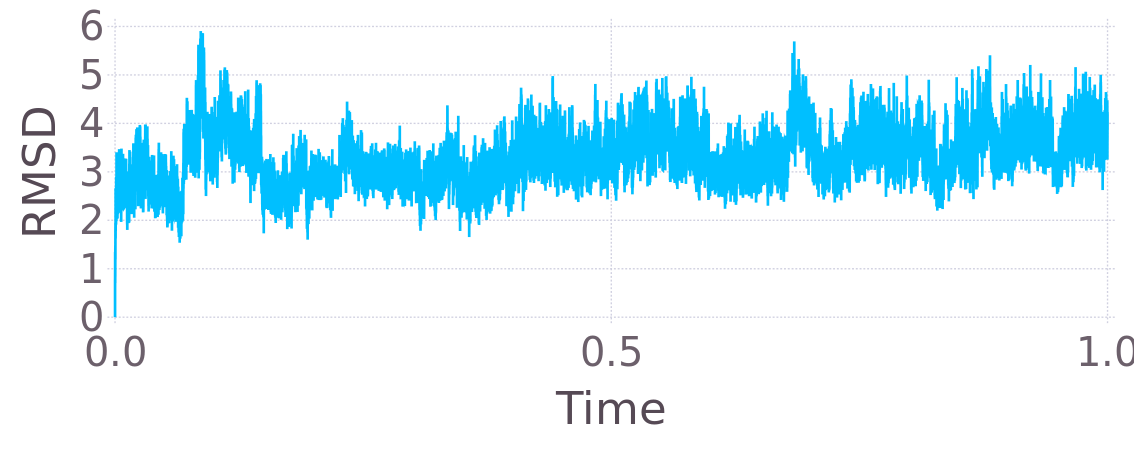

In [4]:
plot(df_r1_cut_rmsd, Geom.line, x="Time", y="RMSD",
    
    #Guide.yticks(ticks = collect(2:2:8)),
    #Guide.xticks(ticks = collect(5:5:57)),
    #Coord.cartesian(ymax = 10.0, xmax = 60, ymin = 1.0),

    Theme(line_width=2pt, grid_line_width=1pt, default_color=colorant"deepskyblue",
        minor_label_font_size = 30pt, major_label_font_size = 34pt, key_label_font_size = 32pt,
        key_title_font_size = 36pt))

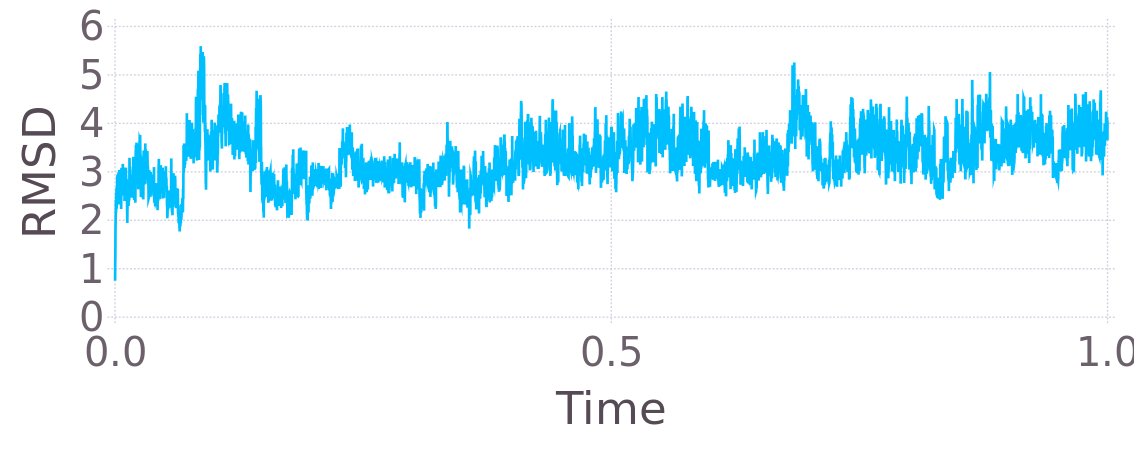

In [5]:
plot(df_r1_smooth_cut_rmsd, Geom.line, x="Time", y="RMSD",
    
    #Guide.yticks(ticks = collect(2:2:8)),
    #Guide.xticks(ticks = collect(5:5:57)),
    #Coord.cartesian(ymax = 10.0, xmax = 60, ymin = 1.0),

    Theme(line_width=2pt, grid_line_width=1pt, default_color=colorant"deepskyblue",
        minor_label_font_size = 30pt, major_label_font_size = 34pt, key_label_font_size = 32pt,
        key_title_font_size = 36pt))

In [14]:
aa = 46
aa3 = aa * 3
aa3_6 = aa3 - 6
half_1_1r_modes, half_1_1r_eigen = read_ptraj_modes(string(main_dir, "run/1r/pca/1half_modes_1r"), aa3);
half_2_1r_modes, half_2_1r_eigen = read_ptraj_modes(string(main_dir, "run/1r/pca/2half_modes_1r"), aa3);

In [22]:
dot(half_1_1r_modes[:, 2], half_2_1r_modes[:, 2])

0.3752754784807808

In [ ]:
[1:10, 1:10]

In [39]:
submat = (transpose(half_1_1r_modes) * half_2_1r_modes)
submat = submat .^ 2
sqrt(sum(submat) / aa3)

0.9770463425622328

## Gráficos finales

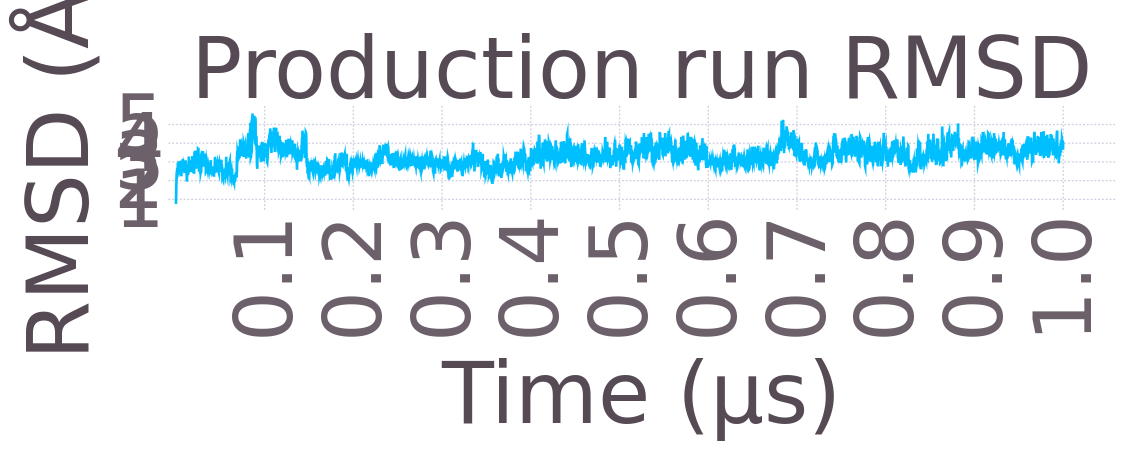

In [6]:
pdf_r1_smooth_cut_rmsd = plot(df_r1_smooth_cut_rmsd, Geom.line, x="Time", y="RMSD",
    
    Guide.title("Production run RMSD"),
    Guide.xticks(ticks = collect(0.1:0.1:1)),
    Guide.yticks(ticks = collect(1:1:5)),
    Coord.cartesian(xmax = 1.05),
    Guide.xlabel("Time (μs)"), 
    Guide.ylabel("RMSD (Å)"), 

    Theme(line_width=2pt, grid_line_width=1pt, default_color=colorant"deepskyblue",
        minor_label_font_size = 60pt, major_label_font_size = 64pt, key_label_font_size = 62pt,
        key_title_font_size = 36pt))

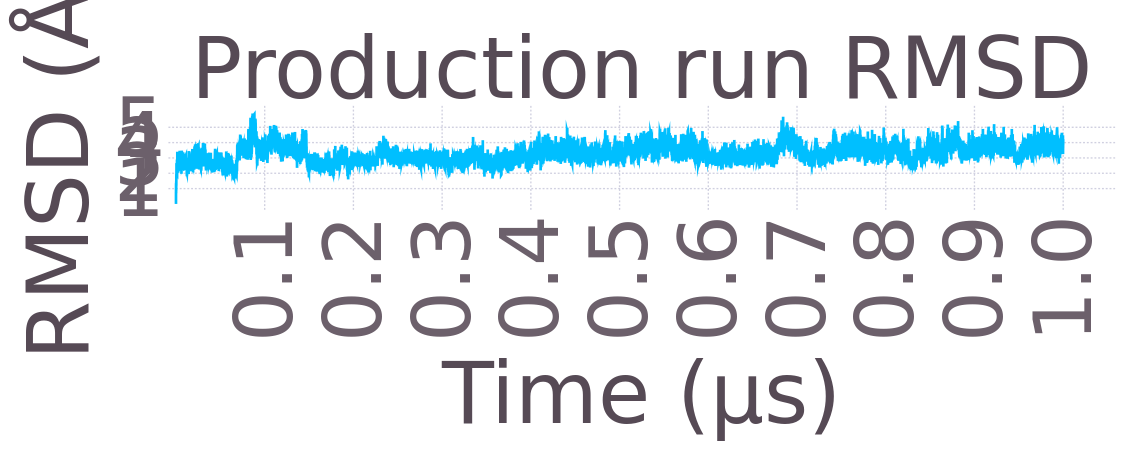

In [7]:
pdf_r1_cut_rmsd = plot(df_r1_cut_rmsd, Geom.line, x="Time", y="RMSD",
    
    Guide.title("Production run RMSD"),
    Guide.xticks(ticks = collect(0.1:0.1:1)),
    Guide.yticks(ticks = collect(1:1:5)),
    Coord.cartesian(xmax = 1.05),
    Guide.xlabel("Time (μs)"),
    Guide.ylabel("RMSD (Å)"), 

    Theme(line_width=2pt, grid_line_width=1pt, default_color=colorant"deepskyblue",
        minor_label_font_size = 60pt, major_label_font_size = 64pt, key_label_font_size = 62pt,
        key_title_font_size = 36pt))

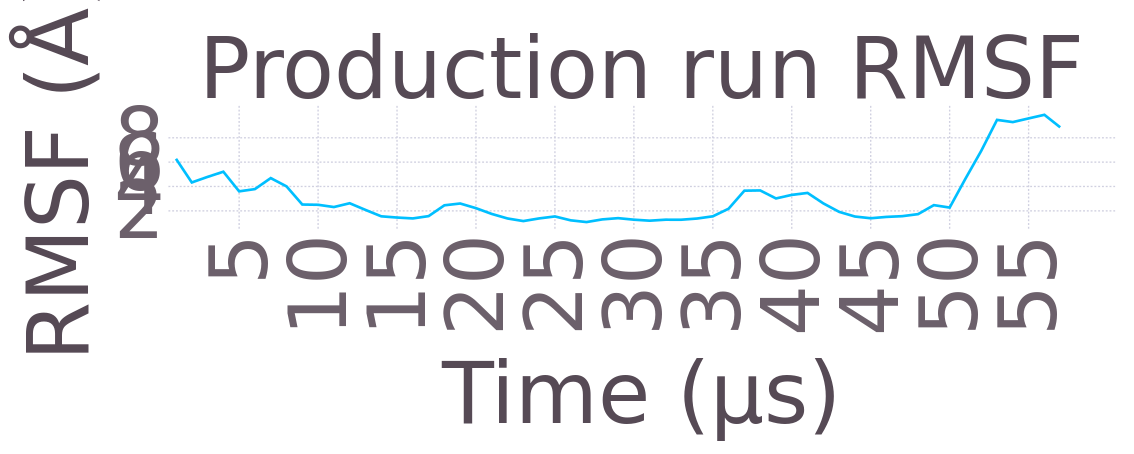

In [8]:
pdf_r1_cut_rmsf = plot(df_r1_cut_rmsf, Geom.line, x="Residue", y="RMSF",
    
    Guide.title("Production run RMSF"),
    Guide.yticks(ticks = collect(2:2:8)),
    Guide.xticks(ticks = collect(5:5:57)),
    Coord.cartesian(ymax = 10.0, xmax = 60, ymin = 1.0),
    Guide.xlabel("Time (μs)"), 
    Guide.ylabel("RMSF (Å)"), 

    Theme(line_width=2pt, grid_line_width=1pt, default_color=colorant"deepskyblue",
        minor_label_font_size = 60pt, major_label_font_size = 64pt, key_label_font_size = 62pt,
        key_title_font_size = 36pt))

In [9]:
# Guardo plots
out_filename_smooth_cut_rmsd = string(main_dir, "rtdos_log/smooth_cut_rmsd.png")
draw(PNG(out_filename_smooth_cut_rmsd, 120cm, 40cm), pdf_r1_smooth_cut_rmsd)

out_filename_cut_rmsd = string(main_dir, "rtdos_log/cut_rmsd.png")
draw(PNG(out_filename_cut_rmsd, 120cm, 40cm), pdf_r1_cut_rmsd)

out_filename_cut_rmsf = string(main_dir, "rtdos_log/cut_rmsf.png")
draw(PNG(out_filename_cut_rmsf, 120cm, 40cm), pdf_r1_cut_rmsf)